In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from poliastro.bodies import Body
from poliastro.twobody import Orbit
from astropy.constants import Constant

In [47]:
import math
import time
import krpc
conn = krpc.connect(name='jupyter')
krpc_bodies = conn.space_center.bodies
krpc_bodies

{'Bop': <SpaceCenter.CelestialBody remote object #12>,
 'Dres': <SpaceCenter.CelestialBody remote object #16>,
 'Duna': <SpaceCenter.CelestialBody remote object #7>,
 'Eeloo': <SpaceCenter.CelestialBody remote object #17>,
 'Eve': <SpaceCenter.CelestialBody remote object #6>,
 'Gilly': <SpaceCenter.CelestialBody remote object #14>,
 'Ike': <SpaceCenter.CelestialBody remote object #8>,
 'Jool': <SpaceCenter.CelestialBody remote object #9>,
 'Kerbin': <SpaceCenter.CelestialBody remote object #2>,
 'Laythe': <SpaceCenter.CelestialBody remote object #10>,
 'Minmus': <SpaceCenter.CelestialBody remote object #4>,
 'Moho': <SpaceCenter.CelestialBody remote object #5>,
 'Mun': <SpaceCenter.CelestialBody remote object #3>,
 'Pol': <SpaceCenter.CelestialBody remote object #15>,
 'Sun': <SpaceCenter.CelestialBody remote object #1>,
 'Tylo': <SpaceCenter.CelestialBody remote object #13>,
 'Vall': <SpaceCenter.CelestialBody remote object #11>}

In [3]:
def _convert_body_krpc_to_poliastro(bodies, parent, krpc_body):
    name = krpc_body.name
    GM = Constant('GM_k{}'.format(name), 'Kerbal {} gravitational constant'.format(name),
                  krpc_body.gravitational_parameter, 'm3 / (s2)', 0,
                  'kRPC space_center.bodies["{}"].gravitational_parameter'.format(name), system='si')
    R = Constant('R_k{}'.format(name), 'Kerbal {} equatorial radius'.format(name),
                      krpc_body.equatorial_radius, 'm', 0,
                     'kRPC space_center.bodies["{}"].equatorial_radius'.format(name), system='si')
    body = Body(parent, GM, "", name, R)
    bodies[name] = body
    for satelite in krpc_body.satellites:
        _convert_body_krpc_to_poliastro(bodies, body, satelite)
    return

def convert_bodies_krpc_to_poliastro(bodies, krpc_bodies):
    krpc_Sun = krpc_bodies["Sun"]
    _convert_body_krpc_to_poliastro(bodies, None, krpc_Sun)
    return
    
bodies = {}
convert_bodies_krpc_to_poliastro(bodies, krpc_bodies)

bodies

{'Bop':  (Bop),
 'Dres':  (Dres),
 'Duna':  (Duna),
 'Eeloo':  (Eeloo),
 'Eve':  (Eve),
 'Gilly':  (Gilly),
 'Ike':  (Ike),
 'Jool':  (Jool),
 'Kerbin':  (Kerbin),
 'Laythe':  (Laythe),
 'Minmus':  (Minmus),
 'Moho':  (Moho),
 'Mun':  (Mun),
 'Pol':  (Pol),
 'Sun':  (Sun),
 'Tylo':  (Tylo),
 'Vall':  (Vall)}

In [4]:
reference_frame = krpc_bodies["Kerbin"].non_rotating_reference_frame

r = krpc_bodies["Mun"].position(reference_frame) * u.m
v = krpc_bodies["Mun"].velocity(reference_frame) * u.m / u.s

ss = Orbit.from_vectors(bodies["Kerbin"], r, v)

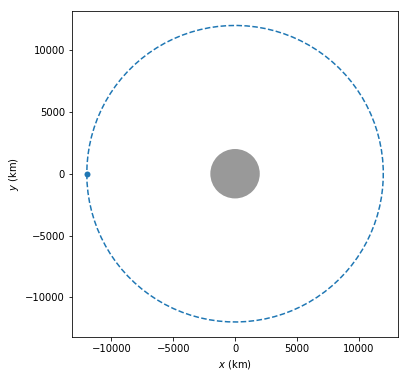

In [5]:
from poliastro.plotting import plot
plot(ss)

In [49]:
vessel = conn.space_center.active_vessel
r = vessel.position(reference_frame) * u.m
v = vessel.velocity(reference_frame) * u.m / u.s
ss_i = Orbit.from_vectors(bodies["Kerbin"], r, v)

NameError: name 'reference_frame' is not defined

In [7]:
from poliastro.maneuver import Maneuver
mun_apoapsis = krpc_bodies["Mun"].orbit.apoapsis
hoh = Maneuver.hohmann(ss_i, mun_apoapsis * u.m)
hoh.get_total_cost()

<Quantity 1.1980721817328461 km / s>

In [8]:
hoh.get_total_time()

<Quantity 26775.142108312208 s>

num_division = 30
tick = 1.5 * vessel.period / num_division

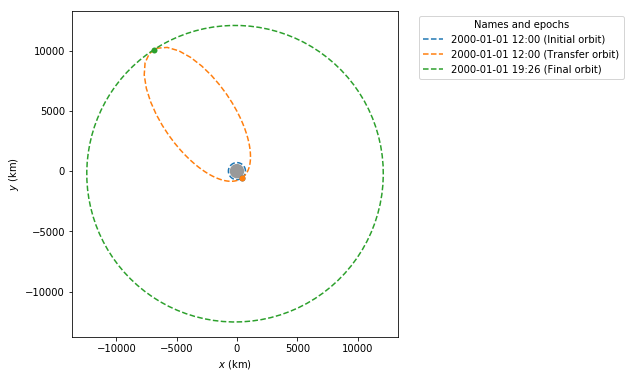

In [13]:
from poliastro.plotting import OrbitPlotter

op = OrbitPlotter()
ss_a, ss_f = ss_i.apply_maneuver(hoh, intermediate=True)
op.plot(ss_i, label="Initial orbit")
op.plot(ss_a, label="Transfer orbit")
op.plot(ss_f, label="Final orbit")

In [19]:
from poliastro.util import norm
delta_v = norm(tuple(val.decompose([u.m, u.s]) for val in hoh[0])[1])

In [24]:
delta_v.value

836.657547108947

In [25]:
ut = conn.space_center.ut
node = vessel.control.add_node(
    ut + 300, prograde=delta_v.value)

In [4]:
vessel = conn.space_center.active_vessel
body = vessel.orbit.body
obt_frame = vessel.orbit.body.non_rotating_reference_frame
srf_frame = vessel.orbit.body.reference_frame

In [5]:
body.rotation_angle

5.933102677204224

In [17]:
for k,v in krpc_bodies.items():
    print("{}: {}".format(k, v.atmosphere_depth))

Sun: 600000.0
Kerbin: 70000.0
Mun: 0.0
Minmus: 0.0
Moho: 0.0
Eve: 55000.0
Duna: 70000.0
Ike: 0.0
Jool: 400000.0
Laythe: 60000.0
Vall: 0.0
Bop: 0.0
Tylo: 0.0
Gilly: 0.0
Pol: 0.0
Dres: 0.0
Eeloo: 0.0


In [32]:
math.log(8000,10000)

0.9757724967479858

In [70]:
from functools import reduce
current_stage = reduce(lambda x,y: max(x, y.decouple_stage, y.stage), vessel.parts.all, 0)
current_stage

3

In [81]:
current_stage_resource = vessel.resources_in_decouple_stage(6)
for r_name in current_stage_resource.names:
    print(r_name, current_stage_resource.amount(r_name))

In [83]:
current_stage_resource.amount("Oxidizer")

0.0